# 3_modeling_evaluation_suto

In [99]:
import os

# Biblioteca built-in para obtenção de combinações
from itertools import combinations

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

# Bibliotecas de modelos
from pycaret.regression import * 
from sklearn.linear_model import LinearRegression, ElasticNet

from sklearn.model_selection import (cross_val_score, cross_validate, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

path_data = "../data/raw/"
path_interim_data = "../data/interim/"

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [100]:
df_data = pd.read_parquet(path_interim_data+"df_data_step_1_output.pqt")

X_train_encoded = pd.read_parquet(path_interim_data+"X_train_encoded_step_2.pqt")
X_test_encoded = pd.read_parquet(path_interim_data+"X_test_encoded_2_output.pqt")

X_train_encoded = pd.concat([X_train_encoded.drop(['car name'], axis=1), df_data.loc[X_train_encoded.index, "mpg"]], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop(['car name'], axis=1), df_data.loc[X_test_encoded.index, "mpg"]], axis=1)

print(f"""Dimensões do dataset de treino: {X_train_encoded.shape}
Dimensões do dataset de validação: {X_test_encoded.shape}""")

Dimensões do dataset de treino: (357, 19)
Dimensões do dataset de validação: (40, 19)


## Testando um vários modelos de regressão usando o PyCaret

In [101]:
regression = setup(data=X_train_encoded, target='mpg')

best = compare_models(sort='MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.9949,7.2631,2.6683,0.8700,0.1099,0.0885,0.0060
br,Bayesian Ridge,1.9992,7.3556,2.6817,0.8684,0.1099,0.0885,0.0060
catboost,CatBoost Regressor,2.2307,9.7129,3.0571,0.8300,0.1189,0.0966,1.3170
gbr,Gradient Boosting Regressor,2.2782,10.1290,3.1400,0.8218,0.1224,0.0996,0.0210
et,Extra Trees Regressor,2.3461,10.8601,3.2294,0.8124,0.1235,0.0998,0.0540
xgboost,Extreme Gradient Boosting,2.3391,11.3468,3.3066,0.8025,0.1269,0.1005,0.3390
rf,Random Forest Regressor,2.5121,12.2757,3.4510,0.7813,0.1305,0.1075,0.0890
ada,AdaBoost Regressor,2.7339,13.9110,3.6857,0.7479,0.1457,0.1225,0.0220
lasso,Lasso Regression,2.8580,14.9702,3.8046,0.7297,0.1492,0.1233,0.0060
lightgbm,Light Gradient Boosting Machine,2.8164,15.0191,3.8202,0.7370,0.1481,0.1219,0.0120


## Testando regressão linear com regularização de rede elástica

### Rodando com valores padrões (*default*)

In [102]:
X = X_train_encoded.drop(['mpg'], axis=1)
y = X_train_encoded['mpg']
scoring='neg_mean_squared_error'
random_state=42

model = ElasticNet(random_state=random_state)
model.fit(X, y)

cross = cross_validate(model, X, y, cv=3, scoring=scoring,
                       return_train_score=True, return_estimator=True, n_jobs=-1)

for key in ['test_score', 'train_score']:
    print(f"""{key}: {round(-cross[key].mean(), 3)}""")

test_score: 8.666
train_score: 7.802


### Tunning do modelo

In [103]:
params = {"alpha":[0.01, 0.05, 0.1, 1, 10],
          "l1_ratio":[0.25, 0.5, 0.75, 0.9, 0.98],
          "selection":['cyclic', 'random']}

grid_search = GridSearchCV(estimator=model, param_grid=params,
                           scoring=scoring, cv=3, n_jobs=-1)

grid_search = grid_search.fit(X, y)
print(grid_search.best_params_)
grid_search.score(X, y)

{'alpha': 0.01, 'l1_ratio': 0.98, 'selection': 'random'}


-7.669498865208671

In [104]:
model = ElasticNet(**grid_search.best_params_, random_state=random_state)
model.fit(X, y)

cross = cross_validate(model, X, y, cv=3, scoring=scoring,
                       return_train_score=True, return_estimator=True, n_jobs=-1)

for key in ['test_score', 'train_score']:
    print(f"""{key}: {round(-cross[key].mean(), 3)}""")

test_score: 8.344
train_score: 7.513


In [105]:
lst_columns = X_train_encoded.columns.tolist()[:-1]
coef_importance = pd.DataFrame(data=model.coef_.reshape(1,-1), columns=lst_columns)

## Plotando

In [106]:
def create_linspace_df(df, features_list=[None], elements_number=100):
    """
    O objetivo desta função é criar um dataframe com uma quantidade de registros igualmente espaçados,
    indicado para usar em regressão.
    
    Inputs:
        df: DataFrame do qual deseja-se criar o domínio igualmente espaçado.
        features_list: lista com as variáveis nu
        elements_number: 100
    
    Output:
        df_result: DataFrame
    """
    import pandas as pd
    
    if features_list[0]==None:
        features_list = df.select_dtypes(include=[float, "float32", "float64"]).columns
    else:
        pass
    
    df_result = pd.DataFrame()
    
    for feature in features_list:
        min_temp = int(df[feature].min()*.95)
        max_temp = int(df[feature].max()*1.05)
        df_result[feature] = np.linspace(min_temp, max_temp, num=elements_number, endpoint=True)
        
    return df_result

In [107]:
df_reg = create_linspace_df(X_test_encoded, features_list=lst_columns)
df_reg

,car brand,model year,cylinders,origin,displacement,horsepower,weight,acceleration,displacement^2,displacement horsepower,displacement weight,displacement acceleration,horsepower^2,horsepower weight,horsepower acceleration,weight^2,weight acceleration,acceleration^2
0,0.0,66.000000,3.000000,0.000000,75.000000,55.000000,1733.000000,10.000000,5928.000000,4352.00000,1.369660e+05,1293.000000,3195.000000,100557.000000,877.000000,3.164093e+06,26817.000000,114.000000
1,0.0,66.202020,3.050505,0.030303,78.484848,56.454545,1764.878788,10.121212,7565.090909,5114.10101,1.539310e+05,1331.696970,3545.606061,108256.797980,892.717172,3.362153e+06,27310.757576,117.929293
2,0.0,66.404040,3.101010,0.060606,81.969697,57.909091,1796.757576,10.242424,9202.181818,5876.20202,1.708960e+05,1370.393939,3896.212121,115956.595960,908.434343,3.560213e+06,27804.515152,121.858586
3,0.0,66.606061,3.151515,0.090909,85.454545,59.363636,1828.636364,10.363636,10839.272727,6638.30303,1.878610e+05,1409.090909,4246.818182,123656.393939,924.151515,3.758273e+06,28298.272727,125.787879
4,0.0,66.808081,3.202020,0.121212,88.939394,60.818182,1860.515152,10.484848,12476.363636,7400.40404,2.048260e+05,1447.787879,4597.424242,131356.191919,939.868687,3.956333e+06,28792.030303,129.717172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,85.191919,7.797980,2.878788,406.060606,193.181818,4761.484848,21.515152,161451.636364,76751.59596,1.748640e+06,4969.212121,36502.575758,832037.808081,2370.131313,2.197979e+07,73723.969697,487.282828
96,0.0,85.393939,7.848485,2.909091,409.545455,194.636364,4793.363636,21.636364,163088.727273,77513.69697,1.765605e+06,5007.909091,36853.181818,839737.606061,2385.848485,2.217785e+07,74217.727273,491.212121
97,0.0,85.595960,7.898990,2.939394,413.030303,196.090909,4825.242424,21.757576,164725.818182,78275.79798,1.782570e+06,5046.606061,37203.787879,847437.404040,2401.565657,2.237591e+07,74711.484848,495.141414
98,0.0,85.797980,7.949495,2.969697,416.515152,197.545455,4857.121212,21.878788,166362.909091,79037.89899,1.799535e+06,5085.303030,37554.393939,855137.202020,2417.282828,2.257397e+07,75205.242424,499.070707


In [108]:
# Criando um dataset com valores de X igualmente espaçados para gerar as retas.
df_reg = create_linspace_df(X_test_encoded, features_list=lst_columns)

# Obtendo as equações de reta para cada relação "fator vs 'mpg'".
dct_equations = {}

model = ElasticNet(**grid_search.best_params_, random_state=random_state)
model.fit(X, y)

str_equation = "y = "+str(round(model.intercept_, 2))

for coef, feature in zip(model.coef_, lst_columns):
    str_equation += " + (" + str(round(coef, 2)) + "*"+feature+")"

df_reg["y_pred_mpg"] = model.predict(df_reg)
    
print(f"Dimensão da matriz: {df_reg.shape}")

str_equation

Dimensão da matriz: (100, 19)


'y = 11.9 + (0.0*car brand) + (0.79*model year) + (0.55*cylinders) + (0.31*origin) + (-0.04*displacement) + (-0.09*horsepower) + (-0.01*weight) + (-1.62*acceleration) + (-0.0*displacement^2) + (0.0*displacement horsepower) + (0.0*displacement weight) + (-0.0*displacement acceleration) + (0.0*horsepower^2) + (-0.0*horsepower weight) + (0.0*horsepower acceleration) + (0.0*weight^2) + (0.0*weight acceleration) + (0.05*acceleration^2)'

### Fatores mais importantes:

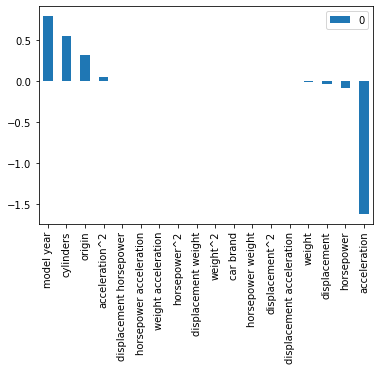

In [133]:
coef_importance = pd.DataFrame.from_dict(dict(zip(lst_columns, model.coef_)), orient='index')
coef_importance.sort_values(by=0, ascending=False).plot(kind='bar');

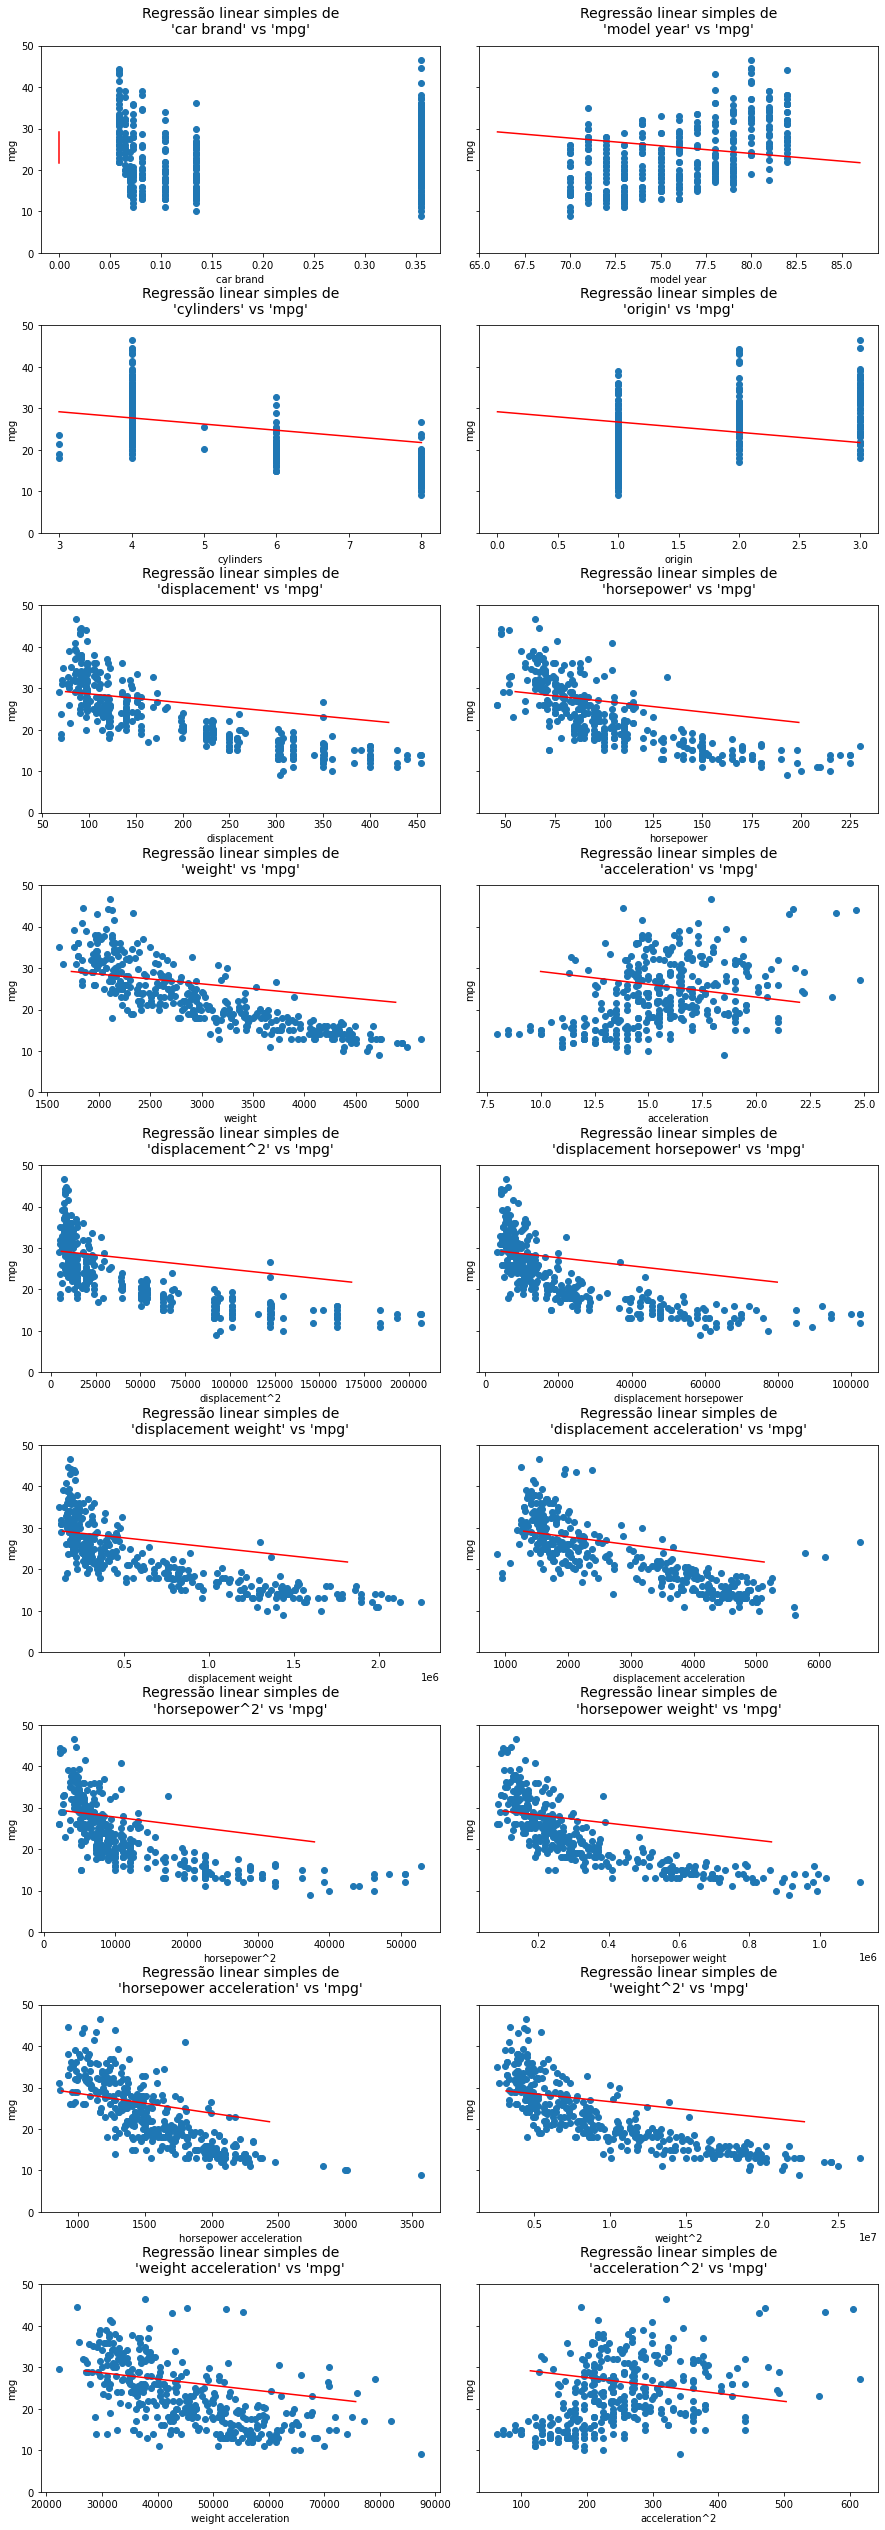

In [117]:
fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(15,45), sharey=True, gridspec_kw={'hspace': .35, 'wspace': .1})

row = col = 0

for i, feature in enumerate(lst_columns):
    axs[row, col].scatter(data=X_train_encoded, x=feature, y="mpg")
    axs[row, col].plot(df_reg[feature], df_reg["y_pred_mpg"], color='red')
    axs[row, col].set_title("Regressão linear simples de\n'"+feature+"' vs 'mpg'",
                            fontdict={'fontsize':14}, pad=12)
    axs[row, col].set(ylim=[0,50], xlabel=feature);
            
#     textstr = f""" Equação da reta: \n{str_equation}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    
#     axs[row, col].text(.65, 0.96, textstr, transform=axs[row, col].transAxes, fontsize=12,
#         verticalalignment='top', bbox=props, color='red');

    if (i+1)%2!=0:
        col += 1
    else:
        col = 0
        row += 1
        
for ax in axs.flat:
    ax.set(ylabel='mpg')